In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [3]:
concat_train = np.concatenate((train_images, test_images), axis=0)
concat_labels = np.concatenate((train_labels, test_labels), axis=0)
concat_train.shape, concat_labels.shape

((70000, 28, 28), (70000, 10))

In [4]:
train_images_150 = []
for i in concat_train:
    img = i
    img2 = cv2.resize(img, dsize=(150,150))
    train_images_150.append(img2)

In [5]:
train_images_150 = np.array(train_images_150)
train_images_150.shape

(70000, 150, 150)

In [6]:
train_dir = 'mnist_num/train'
test_dir = 'mnist_num/test'

import tensorflow as tf
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='categorical', color_mode='grayscale',
    image_size=(150,150), batch_size=98
)

for i, j in test_data.take(1):
    test_data_x = i
    test_data_y = j

test_data_x = np.squeeze(np.array(test_data_x))
test_data_y = np.array(test_data_y)

test_data_x.shape, test_data_y.shape

Found 98 files belonging to 10 classes.


((98, 150, 150), (98, 10))

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='categorical', color_mode='grayscale',
    image_size=(150,150), batch_size=245
)

for i, j in train_data.take(1):
    train_data_x = i
    train_data_y = j

train_data_x = np.squeeze(np.array(train_data_x))
train_data_y = np.array(train_data_y)

train_data_x.shape, train_data_y.shape

Found 245 files belonging to 10 classes.


((245, 150, 150), (245, 10))

In [8]:
# 모든 Train data 합쳐주기
concat_train_x = np.concatenate((train_images_150, train_data_x), axis=0)
concat_train_y = np.concatenate((concat_labels, train_data_y), axis=0)

# Data Normalization
concat_train_x = concat_train_x.astype('float32') / 255
test_data_x = test_data_x.astype('float32') / 255

concat_train_x.shape, concat_train_y.shape

((70245, 150, 150), (70245, 10))

In [9]:
from sklearn.utils import shuffle
X, y = shuffle(concat_train_x, concat_train_y)

In [10]:
X.shape, y.shape

((70245, 150, 150), (70245, 10))

In [11]:
X = np.stack((X, X, X), axis=-1)
X.shape

(70245, 150, 150, 3)

In [12]:
test_data_x = np.stack((test_data_x, test_data_x, test_data_x), axis=-1)
test_data_x.shape

(98, 150, 150, 3)

In [13]:
train_x = X[:60000,:,:]
train_y = y[:60000,:]
validation_x = X[60000:,:,:]
validation_y = y[60000:,:]
train_x.shape, train_y.shape, validation_x.shape, validation_y.shape

((60000, 150, 150, 3), (60000, 10), (10245, 150, 150, 3), (10245, 10))

# Model

In [14]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [16]:
conv_base.trainable = False

In [42]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [43]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 18,914,634
Trainable params: 11,279,370
Non-trainable params: 7,635,264
_________________________________________________________________


In [45]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=5, batch_size=100,
                    validation_data=(validation_x, validation_y))
                

Epoch 1/5
600/600 [==============================] - 64s 105ms/step - loss: 0.0770 - accuracy: 0.9919 - val_loss: 0.0374 - val_accuracy: 0.9961
Epoch 2/5
600/600 [==============================] - 70s 116ms/step - loss: 0.0372 - accuracy: 0.9960 - val_loss: 0.1302 - val_accuracy: 0.9936
Epoch 3/5
600/600 [==============================] - 71s 118ms/step - loss: 0.0332 - accuracy: 0.9969 - val_loss: 0.0580 - val_accuracy: 0.9958
Epoch 4/5
600/600 [==============================] - 71s 119ms/step - loss: 0.0305 - accuracy: 0.9971 - val_loss: 0.0787 - val_accuracy: 0.9939
Epoch 5/5
600/600 [==============================] - 71s 119ms/step - loss: 0.0242 - accuracy: 0.9977 - val_loss: 0.0652 - val_accuracy: 0.9943


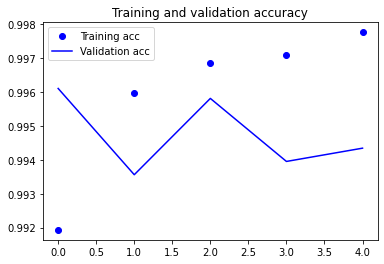

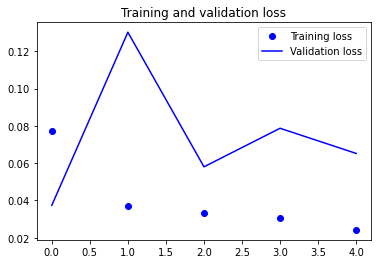

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
model.evaluate(test_data_x, test_data_y)

4/4 [==============================] - 0s 20ms/step - loss: 0.4341 - accuracy: 0.9694


[0.4341133236885071, 0.9693877696990967]

In [48]:
model.fit(validation_x, validation_y, epochs=2, batch_size=100)

Epoch 1/2
103/103 [==============================] - 10s 92ms/step - loss: 0.0825 - accuracy: 0.9929
Epoch 2/2
103/103 [==============================] - 9s 91ms/step - loss: 0.0115 - accuracy: 0.9973


In [49]:
model.evaluate(test_data_x, test_data_y)

4/4 [==============================] - 0s 18ms/step - loss: 2.1696 - accuracy: 0.9388


[2.1696197986602783, 0.9387755393981934]

In [51]:
predict = model.predict(test_data_x)

In [57]:
pred = []
label = []
for i in predict:
    pred.append(np.argmax(i))

for i in test_data_y:
    label.append(np.argmax(i))

pred = np.array(pred)
label = np.array(label)

a = test_data_x[pred != label]
b = pred[pred != label]
a.shape

(6, 150, 150, 3)

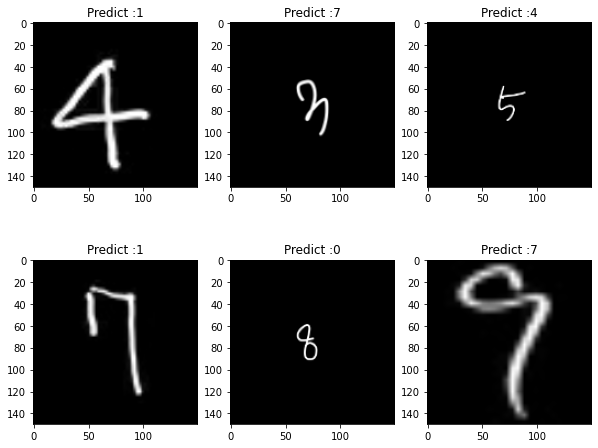

In [62]:
fig = plt.figure(figsize=(10,8))
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    plt.imshow(a[i])
    plt.title("Predict :" + str(b[i]))